In [213]:
import numpy as np
import os
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numba import jit
import IPython as ip
import nolds
import sys
sys.path.insert(0,'./fortran_package/') # carico la directory con i pacchetti
import maps
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import plotly.express as px
import plotly.io as pio
import ComputeLE
import time
importlib.reload(ComputeLE)
from tqdm.notebook import tqdm

In [483]:
importlib.reload(ComputeLE)
def bif_LV(init, beta, down = 0.8, up = 1.3,  n = 100000, sim = 1000, tot_time = 10000):
    # massimi successiviii
    t = np.linspace(0, tot_time, n)
    T = 1000
    tot_inner = 10000
    t_inner = np.linspace(0, T, tot_inner)
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    param = [a, r]
    ss = np.linspace(down,  up, sim)
    x = np.ones((n, 4), dtype=np.float64)*init
    LE = np.empty(sim)
    for i in tqdm(range(len(ss))):
        s = ss[i]
        diag_a = np.diag(a)*np.eye(4) 
        out_a = a - diag_a
        a_in = out_a*s + diag_a
        y, Phi = ComputeLE.complete_motion(t, t_inner, x, a_in, r)
        q = y[:, 0][-int(beta*n):]
        qmax = q[np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True]]
        u = np.random.rand(4)
        u = u / np.linalg.norm(u)
        LE[i] = np.log(np.sqrt(np.sum(np.dot(Phi, u)**2)))/T
        if LE[i] != LE[i]:
            print(Phi, u)
            print(s)
        if i == 0:
            fin_x = np.ones(len(qmax))*s
            fin_y = qmax
        else:
            fin_x = np.concatenate((fin_x, np.ones(len(qmax))*s))
            fin_y = np.concatenate((fin_y, qmax))
    return fin_x, fin_y, LE
init = np.array([0.01, 0.01, 0.01, 0.01])
fin_x, fin_y, LE = bif_LV(init, beta = 0.4, down = 0.8, up = 1.3, n = 50000, sim = 50, tot_time = 5000)

  0%|          | 0/50 [00:00<?, ?it/s]

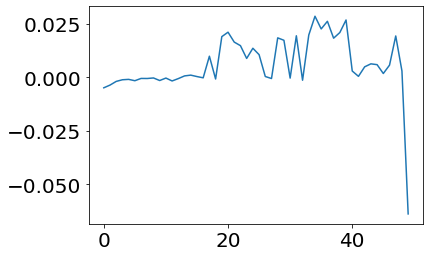

In [484]:
plt.plot(LE)

In [480]:
def LE_big(tot_time=1000, n=100000):
    t = np.linspace(0, tot_time, n)
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    dt = t[1]-t[0]
    param = [a, r]    
    D = 4
    Phi0 = np.eye(D, dtype=np.float64).flatten() # Identità di tipo float
    Ssol = np.append(init, Phi0)
    for i,(t1,t2) in enumerate(zip(t[:-1], t[1:])):
        Ssol_temp = Ssol + ComputeLE.RK4(ComputeLE.dSdt, Ssol, t1, t2, a, r)
        Ssol = Ssol_temp
    Phi_t = np.reshape(Ssol_temp[D:], (D,D))
    u = np.random.rand(4)
    u = u / np.linalg.norm(u)
    LE = np.log(np.sqrt(np.sum(np.dot(Phi_t, u)**2)))/(tot_time)
    print(LE)
LE_big(tot_time=10000, n=10000)

0.020222785655781002


In [425]:
from joblib import Parallel, delayed
interval = np.linspace(0.8, 1.3, 9)
init0 = np.array([0.1, 0.1, 0.1, 0.1])
init1 = np.array([0.01, 0.01, 0.01, 0.01])
init = np.vstack((init0, init0, init0, init0, init1, init1, init1, init1, init1))
nsim = 16000
start = time.time()
res = Parallel(n_jobs=8)(delayed(bif_LV)(init[i], 
                                          beta = 0.3,
                                          down = interval[i], 
                                          up = interval[i+1], 
                                          n = 500000,
                                          sim = int(nsim/7), 
                                          tot_time = 50000) for i in range(len(interval)-1))
print(time.time()-start)
for i, (x, y, l) in enumerate(res):
    if i == 0:
        fin_x = x
        fin_y = y
        LE = l
    else:
        fin_x = np.concatenate((fin_x, x))
        fin_y = np.concatenate((fin_y, y))
        LE = np.concatenate((LE, l))

20.501103162765503


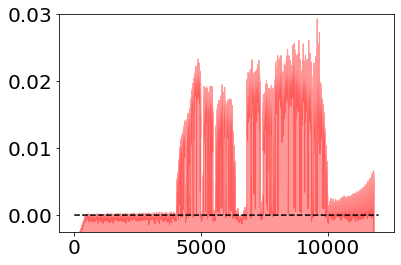

In [377]:
plt.fill_between(np.linspace(0, len(LE), len(LE)), y1 = np.min(LE), y2 = LE, color='r', alpha=0.4)
plt.plot(np.linspace(0, len(LE), len(LE)), np.zeros(len(LE)), linestyle='--', c = 'k')
plt.ylim(-0.0025, 0.03)
plt.show()

In [420]:
#data = np.column_stack((fin_x, fin_y))

In [421]:
#np.savetxt('data/Bif_data.txt', data)

In [422]:
#np.savetxt('data/LE_bif.txt', LE)

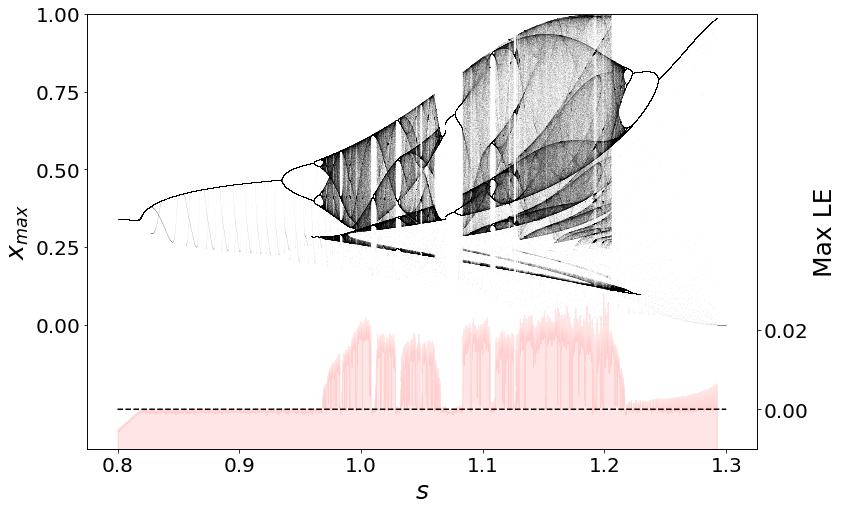

In [419]:
fig, host = plt.subplots(figsize=(12, 8))

par1 = host.twinx()
xx = interval = np.linspace(0.8, 1.3, 12000)

host.scatter(fin_x, fin_y, s = 0.01, c='black', alpha=0.1)
par1.fill_between(xx, y1 = np.min(LE), y2 = LE, color='r', alpha=0.1)
par1.plot(xx, np.zeros(len(LE)), linestyle='--', c = 'k')

host.set_ylim(-0.4, 1.)
par1.set_ylim(-0.01, 0.1)
host.set_ylabel(r'$x_{max}$', fontsize=25)
host.set_xlabel(r'$s$', fontsize=25)
par1.set_ylabel('Max LE', fontsize=25)
par1.set_yticks([0, 0.02])
host.set_yticks(np.linspace(0,1,5))
plt.savefig('../Latex/figures/bif_diag.png', dpi=300)
plt.show()